In [174]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter


import sklearn
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.pipeline import Pipeline 

import os

## Question 1

In [175]:
surv = pd.read_csv('../survival.csv')
surv_copy = surv.copy()
surv.shape

(306, 4)

In [176]:
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [177]:
surv['Survived'].value_counts() 

GE5    225
L5      81
Name: Survived, dtype: int64

In [178]:
surv.isna().sum()

Age         0
Year        0
NNodes      0
Class       0
Survived    0
dtype: int64

In [179]:
class_field = surv.pop('Class')

In [180]:
y = surv.iloc[:,-1:]
X = surv.iloc[:,:-1]

## Baseline - Holdout evaluation

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
sm = SMOTE(sampling_strategy='minority', random_state=10)

bias_holdout = []
accuracy_holdout = []
# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_sample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainX),pd.DataFrame(oversampled_trainY)], axis=1)
oversampled_train.columns = surv_copy.columns
kNN = KNeighborsClassifier(n_neighbors=4)
dt = DecisionTreeClassifier(criterion='gini')
logreg = LogisticRegression(random_state=1)
gb = GradientBoostingClassifier(random_state=42)

y_new = oversampled_train.pop('Class').values
X_new = oversampled_train.values

models = [kNN, dt, logreg, gb]
for m in models:
    y_pred = m.fit(X_new, y_new).predict(X_test)
#     print(X_train.shape,X_test.shape)
    print("Model", type(m).__name__)
    print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))

    pred_neg = Counter(y_pred)['L5']
    test_neg = Counter(np.ravel(y_test))['L5']

    print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
    print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
    bias_rate = pred_neg/test_neg
    print("Bias rate : %0.2f" % bias_rate )
    print(" ")
    bias_holdout.append(bias_rate)
    accuracy_holdout.append(accuracy_score(y_pred, y_test))


Model KNeighborsClassifier
Accuracy:  0.67
Minority class in test set : 0.28
Predicted minority class : 0.28
Bias rate : 1.00
 
Model DecisionTreeClassifier
Accuracy:  0.70
Minority class in test set : 0.28
Predicted minority class : 0.24
Bias rate : 0.85
 
Model LogisticRegression
Accuracy:  0.70
Minority class in test set : 0.28
Predicted minority class : 0.30
Bias rate : 1.08
 
Model GradientBoostingClassifier
Accuracy:  0.70
Minority class in test set : 0.28
Predicted minority class : 0.33
Bias rate : 1.15
 


In [182]:
from sklearn.metrics import make_scorer
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

folds = 5
v = 0 

#### Cross val without SMOTE

In [197]:
bias_xval_without_smote = []
accuracy_xval_without_smote = []

kNN = KNeighborsClassifier(n_neighbors=6)  
dt = DecisionTreeClassifier(criterion='entropy')
logreg = LogisticRegression(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

models = [kNN,dt,logreg,gb]
for m in models:
    pipe = Pipeline(steps=[
    ('classifier', m)])
    y1 = np.ravel(y)
    skf = StratifiedKFold(n_splits=folds)
    cv_results = cross_validate(pipe, X, y1, cv= skf,scoring=scoring, return_train_score=False, 
                                verbose = v, n_jobs = -1)
    bias =0
    accuracy = 0
    for i in range(folds):
        bias = bias + cv_results['test_tp'][i]/(cv_results['test_tp'][i]+cv_results['test_fn'][i])
        accuracy = accuracy + (cv_results['test_tp'][i]+cv_results['test_tn'][i])/(len(X)/folds)
    print("Model", type(m).__name__, "Without SMOTE")
    bias1 = np.round(bias/folds,2)
    acc1 = np.round(accuracy/folds,2)
    print("Bias", bias1)
    print("Accuracy", acc1)
    print(" ")
    bias_xval_without_smote.append(bias1)
    accuracy_xval_without_smote.append(acc1)


Model KNeighborsClassifier Without SMOTE
Bias 0.27
Accuracy 0.75
 
Model DecisionTreeClassifier Without SMOTE
Bias 0.42
Accuracy 0.64
 
Model LogisticRegression Without SMOTE
Bias 0.17
Accuracy 0.75
 
Model GradientBoostingClassifier Without SMOTE
Bias 0.28
Accuracy 0.64
 


#### Cross val with SMOTE

In [237]:
bias_xval_with_smote = []
accuracy_xval_with_smote = []

for m in models:
    pipe  = Pipeline(steps=[('sampling', SMOTE(sampling_strategy ='minority')),
                            ('scaling', StandardScaler()),
                            ('classifier', m)])
    y1 = np.ravel(y)
    cv_results = cross_validate(pipe, X, y1, cv= folds,scoring=scoring, return_train_score=False, 
                                verbose = v, n_jobs = -1)
    bias =0
    accuracy = 0
    for i in range(folds):
        bias = bias + cv_results['test_tp'][i]/(cv_results['test_tp'][i]+cv_results['test_fn'][i])
        accuracy = accuracy + (cv_results['test_tp'][i]+cv_results['test_tn'][i])/(len(X)/folds)
    print("Model", type(m).__name__, "With SMOTE")
    bias1 = np.round(bias/folds,2)
    acc1 = np.round(accuracy/folds,2)
    print("Bias", bias1)
    print("Accuracy", acc1)
    print(" ")
    bias_xval_with_smote.append(bias1)
    accuracy_xval_with_smote.append(acc1)


Model KNeighborsClassifier With SMOTE
Bias 0.41
Accuracy 0.64
 
Model DecisionTreeClassifier With SMOTE
Bias 0.39
Accuracy 0.65
 
Model LogisticRegression With SMOTE
Bias 0.53
Accuracy 0.64
 
Model GradientBoostingClassifier With SMOTE
Bias 0.41
Accuracy 0.63
 


In [238]:
model_name = []
for m in models:
    model_name.append(type(m).__name__)

In [239]:
scores = pd.DataFrame()
scores['model'] = model_name
scores['holdout_bias'] = bias_holdout
scores['holdout_acc'] = accuracy_holdout
scores['xval_without_SMOTE_bias'] = bias_xval_without_smote
scores['xval_without_SMOTE_acc'] = accuracy_xval_without_smote
scores['xval_with_SMOTE_bias'] = bias_xval_with_smote
scores['xval_with_SMOTE_acc'] = accuracy_xval_with_smote

In [240]:
scores.set_index('model', inplace=True)
scores.head()

,holdout_bias,holdout_acc,xval_without_SMOTE_bias,xval_without_SMOTE_acc,xval_with_SMOTE_bias,xval_with_SMOTE_acc
model,,,,,,
KNeighborsClassifier,1.000000,0.673913,0.27,0.75,0.41,0.64
DecisionTreeClassifier,0.846154,0.695652,0.42,0.64,0.39,0.65
LogisticRegression,1.076923,0.695652,0.17,0.75,0.53,0.64
GradientBoostingClassifier,1.153846,0.695652,0.28,0.64,0.41,0.63


Text(0.5, 1.0, 'Bias rates of different models for holdout/smote/without smote')

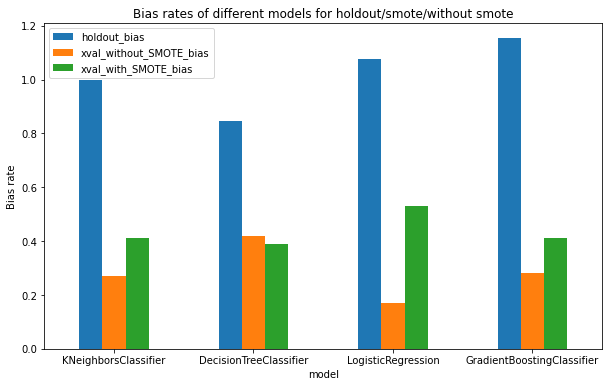

In [241]:
scores[['holdout_bias','xval_without_SMOTE_bias','xval_with_SMOTE_bias']].plot.bar(rot=0, figsize=(10, 6))
plt.ylabel('Bias rate')
plt.title('Bias rates of different models for holdout/smote/without smote')

The above graph represents the Bias rate for
1. Holdout evaluation
2. X Val evaluation without SMOTE
3. X Val evaluation with SMOTE

Even though X Val evaluation with SMOTE does not perform as well as holdout evaluation with respect to bias rate, it performs better tgan XVal evaluation without SMOTE for all the 4 models. 

Logistic Regression has the best bias rate of the 4 models (This has approximately 300% increase in bias when using SMOTE as opposed to not using SMOTE)

Pipeline was used to perform SMOTE, scaling and subsequently fitting the classifier model.

SMOTE was used for balancing the imbalanced class, StandardScaler was used for scaling and the 4 models were used in a loop after initialization

XVal Evaluation with SMOTE is still biased because of the type of evaluation happening in cross validation. The data provided is also less to evaluate properly with cross validation.

The results of crossval is generally considered more robust than holdout testing because the representation of the test data is split across the dataset in cross validation whereas in holdout evaluation it may be biased towards one class of data because of the test train split

The bias for holdout is less because we are testing on the same data points everytime unlike cross validation.

For example in the case of cross validation in some splits, there may be very less number of the minority class leading to more bias. This problem is only exemplified by the small size of the dataset

Text(0.5, 1.0, 'Accuracy of different models for holdout/smote/without smote')

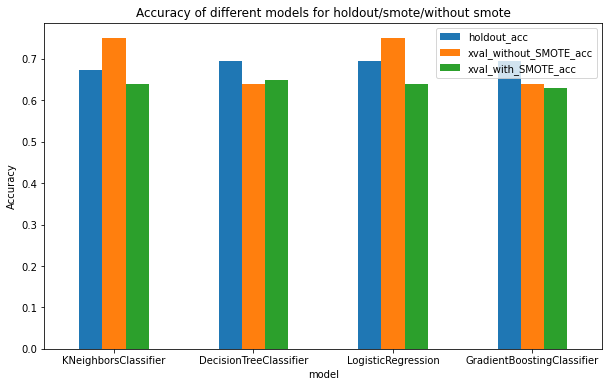

In [242]:
scores[['holdout_acc','xval_without_SMOTE_acc','xval_with_SMOTE_acc']].plot.bar(rot=0, figsize=(10, 6))
plt.ylabel('Accuracy')
plt.title('Accuracy of different models for holdout/smote/without smote')

As we can see from the above graph, there is only a minor change in the accuracy with and without smote. But the accuracy has reduced a bit because of the use of an upsampling technique. This is expected because we are reduceing bias and there is a tradeoff between bias and accuracy

### Question 2

Let's read the data. The data was already in a train-test format

In [2]:
heart_train = pd.read_csv('heart-train.csv')
heart_test = pd.read_csv('heart-test.csv')

In [3]:
heart_train.shape,heart_test.shape

((199, 13), (100, 13))

In [4]:
heart_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,60.0,0,253,0,35,0,279000.00,1.70,140,1,0,250,0
1,40.0,1,129,0,35,0,255000.00,0.90,137,1,0,209,0
2,86.0,0,582,0,38,0,263358.03,1.83,134,0,0,95,1
3,45.0,0,582,0,35,0,385000.00,1.00,145,1,0,61,1
4,72.0,0,127,1,50,1,218000.00,1.00,134,1,0,33,0


There are no null values in the dataset. So no imputation is required

In [5]:
heart_train.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Let's look at how the train data is distributed.

1 - Death

0 - No death

Text(0.5, 1.0, 'Distribution of the y variable on the train set')

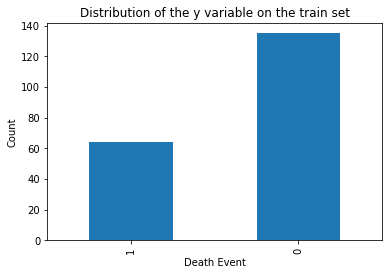

In [6]:
heart_train['DEATH_EVENT'].value_counts().sort_values().plot(kind = 'bar')
plt.xlabel('Death Event')
plt.ylabel('Count')
plt.title('Distribution of the y variable on the train set')

Text(0.5, 1.0, 'Distribution of the y variable on the test set')

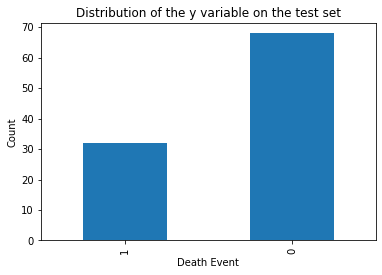

In [7]:
heart_test['DEATH_EVENT'].value_counts().sort_values().plot(kind = 'bar')
plt.xlabel('Death Event')
plt.ylabel('Count')
plt.title('Distribution of the y variable on the test set')

In [8]:
## Splitting X variable and y variable in both test and train set
train_y = heart_train.iloc[:,-1:]
train_X = heart_train.iloc[:,:-1]

test_y = heart_test.iloc[:,-1:]
test_X = heart_test.iloc[:,:-1]

Let's visualise the data in the train set to see how it is distributed

In [9]:
train_X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,60.0,0,253,0,35,0,279000.00,1.70,140,1,0,250
1,40.0,1,129,0,35,0,255000.00,0.90,137,1,0,209
2,86.0,0,582,0,38,0,263358.03,1.83,134,0,0,95
3,45.0,0,582,0,35,0,385000.00,1.00,145,1,0,61
4,72.0,0,127,1,50,1,218000.00,1.00,134,1,0,33


Most people are in the age range 55-65 

This is mainly because we are dealing with a dataset of heart disease and people around this age tend to be affected by the disease


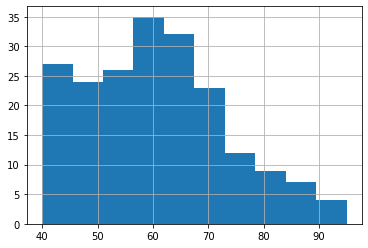

In [10]:
train_X['age'].hist()

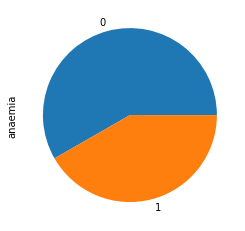

In [11]:
# Distribution of anaemia
train_X['anaemia'].value_counts().plot(kind='pie')

Ejection fraction distribution. Looking at the distribution, it is concentrated around 35-40 and might have an impact on the result


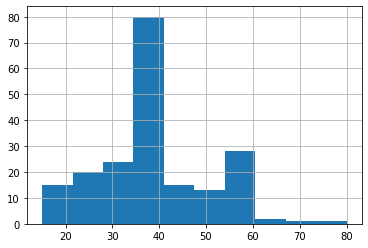

In [12]:
train_X['ejection_fraction'].hist()

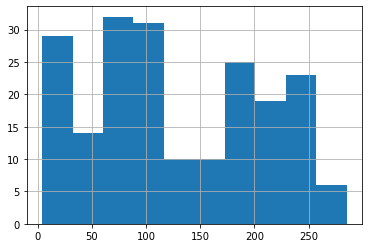

In [13]:
train_X['time'].hist()

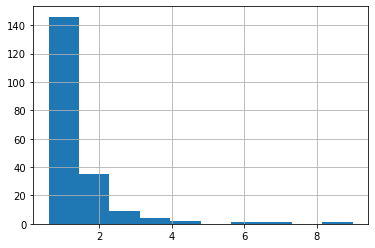

In [14]:
train_X['serum_creatinine'].hist()

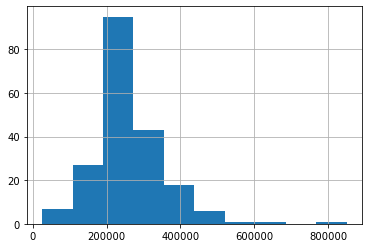

In [15]:
# Platelets is normally distributed
train_X['platelets'].hist()

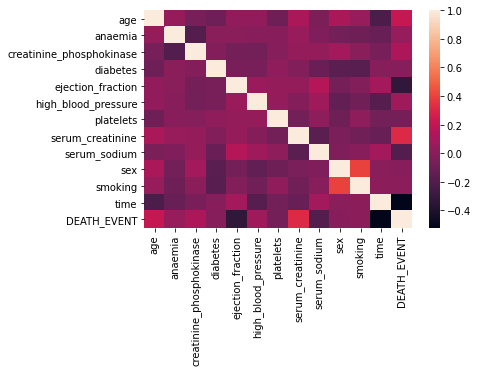

In [16]:
# The correlation plot does not contain a lot of info because it is right out of the box wihtout a lot of feature engineering
# Serum_creatinine has the highest corr for the variable death_event
import seaborn as sns
corr = heart_train.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Scaling is not required because the model that we are using is a Boosted tree method (GradientBoost) and scaling doesn't make sense for decision trees and ensemble trees

In [17]:
# scaler = StandardScaler()
# scaler.fit(train_X)
# scaled_train_X = scaler.transform(train_X)

#### Baseline results

In [18]:
accu = []
preci = []
reca = []
dataframe = pd.DataFrame()
gbc = GradientBoostingClassifier(random_state=0, n_estimators = 200, learning_rate = 0.01, min_samples_split = 3)
for i in range(2,11):
    cv_results = cross_validate(gbc, train_X, np.ravel(train_y), cv=i, scoring=['accuracy','recall','precision'])
    accu.append(np.round(cv_results['test_accuracy'].mean(),2))
    preci.append(np.round(cv_results['test_precision'].mean(),2))
    reca.append(np.round(cv_results['test_recall'].mean(),2))

dataframe['folds'] = range(2,11)
dataframe['recall'] = reca
dataframe['precision'] = preci
dataframe['accuracy'] = accu    
dataframe['F1-Score'] = np.round((2*dataframe['precision']*dataframe['recall'])/(dataframe['precision']+dataframe['recall']),2)
    

In [19]:
dataframe

,folds,recall,precision,accuracy,F1-Score
0,2,0.62,0.73,0.80,0.67
1,3,0.61,0.76,0.81,0.68
2,4,0.66,0.74,0.81,0.70
3,5,0.59,0.71,0.78,0.64
4,6,0.64,0.74,0.80,0.69
5,7,0.62,0.71,0.80,0.66
6,8,0.69,0.72,0.81,0.70
7,9,0.63,0.72,0.80,0.67
8,10,0.63,0.74,0.80,0.68


From the above dataframe we can interpret that folds = 8 has the best combination of accuracy and F1-score

In [20]:
folds = 8
gbc = GradientBoostingClassifier(random_state=0, n_estimators = 200, learning_rate = 0.01, min_samples_split = 3)

cv_results = cross_validate(gbc, train_X, np.ravel(train_y), cv=folds, scoring=['accuracy','recall','precision'])
# cv_results

Cross validation was performed on the train set with 8 folds

In [21]:
print("Baseline accuracy using 8 fold X-Val is", np.round(cv_results['test_accuracy'].mean(),2))
print("Baseline precision using 8 fold X-Val is", np.round(cv_results['test_precision'].mean(),2))
print("Baseline recall using 8 fold X-Val is", np.round(cv_results['test_recall'].mean(),2))

Baseline accuracy using 8 fold X-Val is 0.81
Baseline precision using 8 fold X-Val is 0.72
Baseline recall using 8 fold X-Val is 0.69


Testing on the test set using holdout testing. Gradient boost model was trained on the provided train set

In [22]:
gbc.fit(train_X, np.ravel(train_y))
pred_y = gbc.predict(test_X)
print("Baseline accuracy using holdout testing is", accuracy_score(test_y, pred_y))
print("Baseline precision using holdout testing is", np.round(precision_score(test_y, pred_y),2))
print("Baseline recall using holdout testing is", np.round(recall_score(test_y, pred_y),2))

Baseline accuracy using holdout testing is 0.85
Baseline precision using holdout testing is 0.77
Baseline recall using holdout testing is 0.75


### Using K-Best to select best features

Defining 3 functions. They were picked and then further modified from the provided notebook tutorials from the ML class

In [25]:
def calculate_ig_gain(data_X, data_y):
    '''
    Calculate Information gain given X and y of the train data
    Input - X and y variables of train data
    Output - Dataframe with with IG gain values sorted per feature
    '''
    mutual_info = dict()
    i_scores = mutual_info_classif(data_X, np.ravel(data_y))

    for i,j in zip(data_X.columns,i_scores):
        mutual_info[i]=j

    df = pd.DataFrame.from_dict(mutual_info,orient='index',columns=['I-Gain'])
    df.sort_values(by=['I-Gain'],ascending=False,inplace=True)
    return df

def kbest_select(df, data_train_X,data_train_y, split_type, data_test_X, data_test_y):
    '''
    Test various values of k in k-best for feature selection. We use mutual_info_classif to rank the features.
    The function has been split for a XVal method and a holdout method because we calculate scores differently in the two methods. 
    The test data will also be different in xval and holdout
    
    Input :
    df - Dataframe from calculate_ig_gain function
    data_train_X - X variable in training data
    data_train_y - y variable in training data
    split_type - xval for cross validation and holdout for holdout testing
    data_test_X - X varaible in testing data for holdout testing
    data_test_y - y variable in testing data for holdout testing
    
    Output :
    Dataframe with IG-value and various calculated scores
    
    '''
    acc_scores = []
    recall_scores = []
    precision_scores = []
    for kk in range(1, data_train_X.shape[1]+1):
        train_kbest = SelectKBest(mutual_info_classif, score_func  ='mutual_info_classif', k = kk).fit(data_train_X, np.ravel(data_train_y))
        
        if split_type=="xval":
            new_train_X = train_kbest.transform(data_train_X)
            cv_results1 = cross_validate(gbc, new_train_X, np.ravel(train_y), cv=5, scoring=['accuracy','recall','precision'])
            acc = cv_results1['test_accuracy'].mean()
            rec = cv_results1['test_recall'].mean()
            prec = cv_results1['test_precision'].mean()
        
        elif split_type=="holdout":
            new_train_X = train_kbest.transform(data_train_X)
            new_test_X = train_kbest.transform(data_test_X)
            gbc.fit(new_train_X, np.ravel(data_train_y))
            pred_y = gbc.predict(new_test_X)

            acc = accuracy_score(data_test_y, pred_y)
            rec = recall_score(data_test_y, pred_y)
            prec = precision_score(data_test_y, pred_y)
            
        acc_scores.append(acc)
        recall_scores.append(rec)
        precision_scores.append(prec)
    df['Accuracy'] = acc_scores
    df['Recall'] = recall_scores
    df['Precision'] = precision_scores
    df['F1-Score'] = 2*(df['Precision']*df['Recall'])/(df['Precision']+df['Recall'])
    return df

def plot_feature_metrics(data, metric_to_plot):
    '''
    Plot a bar graph with a superimposed line graph.
    Bar graph - IG gain
    Line graph - Metric
    
    Input :
    data - output dataframe from the function kbest_select
    metric_to_plot - Accuracy/Precision/Recall/F1-score to plot a line graph
    
    Output :
    Matplotlib plot
    '''
    n = len(data.index)
    rr = range(1,n)
    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    ax.bar(data.index, data["I-Gain"], label='I-Gain',width=.4, color ='green')
    ax2.plot(data.index, data[metric_to_plot], color='blue', label=metric_to_plot)

    ax.set_xticklabels(list(data.index), rotation = 90)
    ax.set_xlabel('Features')
    ax.set_ylabel('I-Gain')
    ax2.set_ylabel(metric_to_plot)
    ax.legend()

    plt.show()

Let's calculate IG-gain and various metrics using cross validation

In [29]:
df_xval = calculate_ig_gain(train_X,train_y)
df_xval1 = kbest_select(df_xval,train_X,train_y, "xval", test_X, test_y)

In [30]:
df_xval1

,I-Gain,Accuracy,Recall,Precision,F1-Score
time,0.222937,0.804487,0.534615,0.814524,0.645533
serum_creatinine,0.115425,0.784615,0.582051,0.699675,0.635466
ejection_fraction,0.099040,0.814615,0.658974,0.734895,0.694867
high_blood_pressure,0.029812,0.799359,0.641026,0.720278,0.678345
smoking,0.027187,0.804359,0.626923,0.725944,0.672810
creatinine_phosphokinase,0.024899,0.804359,0.656410,0.725833,0.689378
age,0.024535,0.799359,0.641026,0.720000,0.678222
anaemia,0.005826,0.784359,0.594872,0.704921,0.645237
diabetes,0.000000,0.784359,0.594872,0.708892,0.646896
platelets,0.000000,0.789359,0.610256,0.714124,0.658117


Let's look at the various plots

The line graph represents the scores (Accuracy/Precision/Recall/F1) when different features are tried out when it's ranked in the decreasing order of IG gain

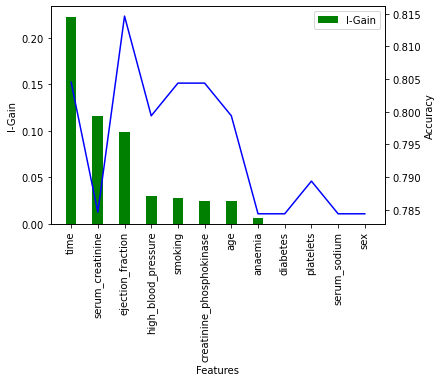

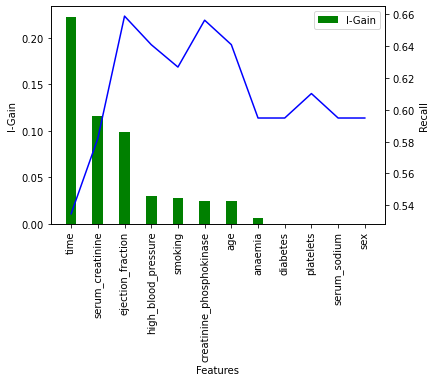

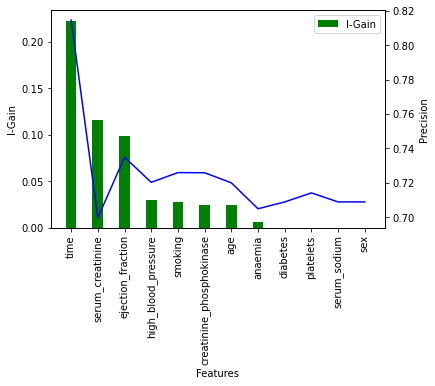

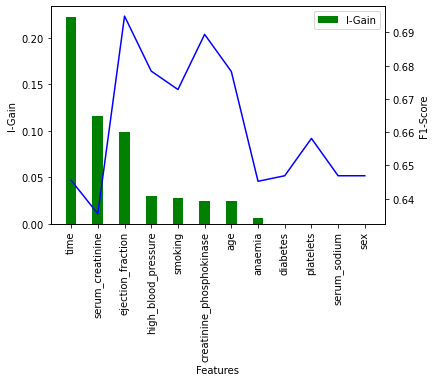

(None, None, None, None)

In [31]:
# 
plot_feature_metrics(df_xval1,"Accuracy"), plot_feature_metrics(df_xval1,"Recall"), plot_feature_metrics(df_xval1,"Precision"), plot_feature_metrics(df_xval1,"F1-Score")

From the above graphs we can interpret that the F1-score, accuracy and recall is at the feature "ejection_fraction" (First 3 features ranked in the reverse IG gain order)

Disclaimer - At different runs this might produce different results because of the way the function K-best and mutual_info_classif() works when data is provided in different splits in xval. In my particular run, the first 3 features produced the best results.

The results produced are not stable and it keeps fluctuating with different runs. In my testing so far it has varied from fetures 4 to 8

In [33]:
## To find the best features when ranked by IG gain
maxidx = df_xval1['F1-Score'].idxmax()
index_list = df_xval1.index == maxidx
index_of_true = np.where(index_list)[0][0]
index_of_true

2

index_of_true+1 contains the value of optimal k from our analysis.

This is a dynamic calculation because the value changes with every function

In the above cells, we tested our feature selection algorithm using Xval on the train set. Let us see if this parameter holds good in the test set when tested with the same k in holdout testing

In [34]:
kk = index_of_true+1
train_kbest = SelectKBest(mutual_info_classif, score_func  ='mutual_info_classif', k = kk).fit(train_X, np.ravel(train_y))
new_train_X = train_kbest.transform(train_X)
new_test_X = train_kbest.transform(test_X)
gbc.fit(new_train_X, np.ravel(train_y))
pred_y = gbc.predict(new_test_X)
accuracy_score(test_y, pred_y), recall_score(test_y, pred_y), precision_score(test_y, pred_y)

(0.85, 0.6875, 0.8148148148148148)

In [36]:
df_holdout = calculate_ig_gain(train_X,train_y)
df_holdout1 = kbest_select(df_holdout,train_X,train_y, "holdout", test_X, test_y)

The dataframe df_holdout contains the calculated ig gain values on the train set

The dataframe df_holdout1 contains the scores at different points of K in the K-best algorithm. The scores that we will consider are accuracy and F1-score because F1 contains both precision and recall in it.
But in a medical scenario it makes more sense to consider recall as we want to eliminate false negatives

In [38]:
df_holdout1

,I-Gain,Accuracy,Recall,Precision,F1-Score
time,0.219658,0.83,0.65625,0.777778,0.711864
serum_creatinine,0.067432,0.86,0.75000,0.800000,0.774194
ejection_fraction,0.056587,0.87,0.78125,0.806452,0.793651
high_blood_pressure,0.043202,0.87,0.78125,0.806452,0.793651
smoking,0.024497,0.88,0.78125,0.833333,0.806452
serum_sodium,0.019853,0.87,0.78125,0.806452,0.793651
age,0.011547,0.87,0.78125,0.806452,0.793651
creatinine_phosphokinase,0.001884,0.87,0.78125,0.806452,0.793651
anaemia,0.001427,0.85,0.75000,0.774194,0.761905
diabetes,0.000000,0.85,0.75000,0.774194,0.761905


K was 8 in the previous case when we used cross validation but here we can see that at K=8(anaemia) , the accuracy and f1 scores aren't at maximum. let's confirm this visually with a plot

Let's visualise the scores using the previously defined functions

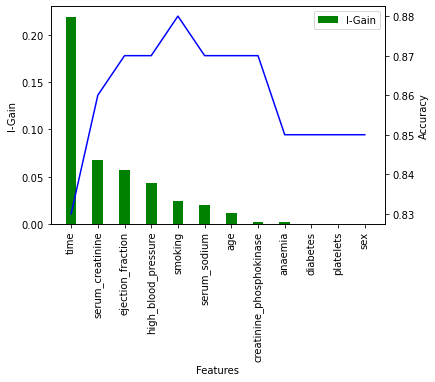

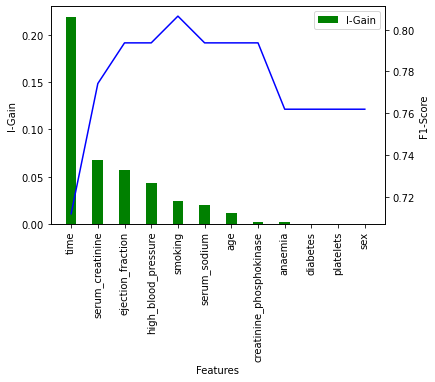

(None, None)

In [40]:
plot_feature_metrics(df_holdout1,"Accuracy"), plot_feature_metrics(df_holdout1,"F1-Score")

According to the plots of scores in holdout testing, k should be 6 and not 3. 

Accuracy is at the maximum when features till "High_blood_pressure" are considered

The test data was not used for classifier training or feature selection. We are only testing and comparing with the features we got from the xval results and these aren't the best performing features in holdout testing


One reason for this could be the difference in testing data between xval and holdout testing. Normally, the results of xval are considered quite stable when compared to testing data because different datapoints are tested in different folds in xval

Let's run the same cells again to check if the results are stable and consistent.

Using the same xval code in the below cells to check stability and consistency

In [43]:
df_xval_check_stability = calculate_ig_gain(train_X,train_y)
df_xval_check_stability1 = kbest_select(df_xval_check_stability,train_X,train_y, "xval", test_X, test_y)

In [48]:
## Plot of the initial XVAL

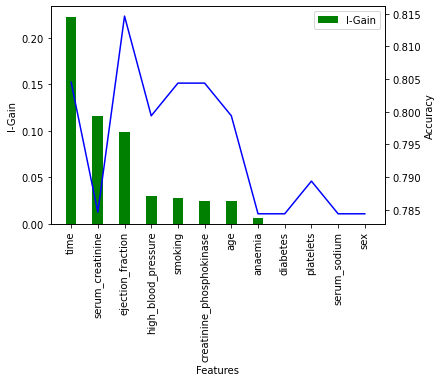

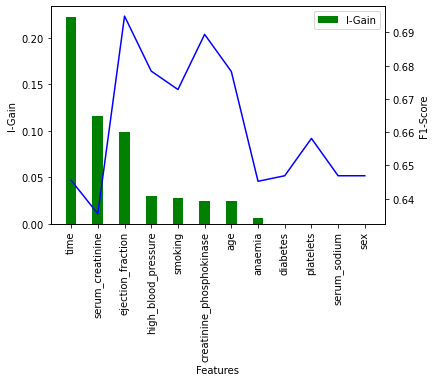

(None, None)

In [49]:
plot_feature_metrics(df_xval1,"Accuracy"), plot_feature_metrics(df_xval1,"F1-Score")

Plot of the current xval to check stability

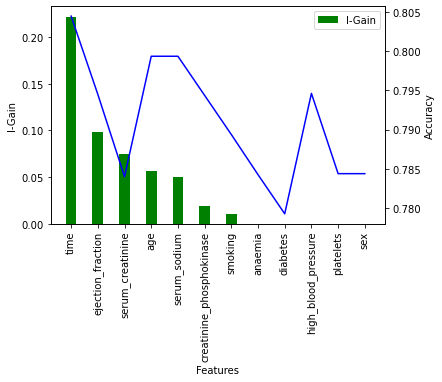

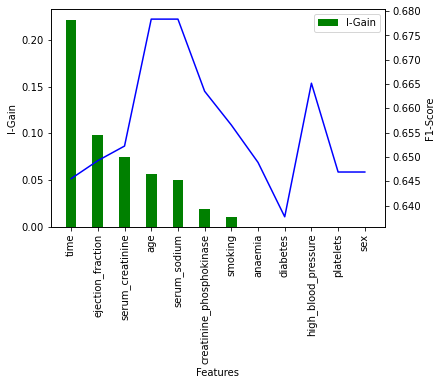

(None, None)

In [51]:
plot_feature_metrics(df_xval_check_stability1,"Accuracy"), plot_feature_metrics(df_xval_check_stability1,"F1-Score")

df_xval1 - Dataframe from our initial xval run to select k best features

df_xval_check_stability1 - Dataframe currently when calling the same function to check stability of the method used

In [52]:
df_xval1

,I-Gain,Accuracy,Recall,Precision,F1-Score
time,0.222937,0.804487,0.534615,0.814524,0.645533
serum_creatinine,0.115425,0.784615,0.582051,0.699675,0.635466
ejection_fraction,0.099040,0.814615,0.658974,0.734895,0.694867
high_blood_pressure,0.029812,0.799359,0.641026,0.720278,0.678345
smoking,0.027187,0.804359,0.626923,0.725944,0.672810
creatinine_phosphokinase,0.024899,0.804359,0.656410,0.725833,0.689378
age,0.024535,0.799359,0.641026,0.720000,0.678222
anaemia,0.005826,0.784359,0.594872,0.704921,0.645237
diabetes,0.000000,0.784359,0.594872,0.708892,0.646896
platelets,0.000000,0.789359,0.610256,0.714124,0.658117


In [53]:
df_xval_check_stability1

,I-Gain,Accuracy,Recall,Precision,F1-Score
time,0.221893,0.804487,0.534615,0.814524,0.645533
ejection_fraction,0.098566,0.794487,0.580769,0.736004,0.649236
serum_creatinine,0.074532,0.783974,0.606410,0.705556,0.652237
age,0.055980,0.799359,0.641026,0.720278,0.678345
serum_sodium,0.049802,0.799359,0.641026,0.720278,0.678345
creatinine_phosphokinase,0.019174,0.794359,0.610256,0.726944,0.663509
smoking,0.010105,0.789359,0.610256,0.710476,0.656564
anaemia,0.000000,0.784231,0.610256,0.692698,0.648869
diabetes,0.000000,0.779231,0.594872,0.687143,0.637687
high_blood_pressure,0.000000,0.794615,0.628205,0.706739,0.665162


#### As we can see from the graphs and the dataframes in the above 2 cells, the results are not consistent with respect to any of the scores. A possible reason could be how the data is split into folds differently in each run. But with different data in each fold we expect to see changes in accuracy, thereby affecting the k best algorithm.

#### The values of IG gain has also changes in the 2 dataframes leading to different values of feature importances

In [54]:
df_check_holdout_stability = calculate_ig_gain(train_X,train_y)
df_check_holdout_stability1 = kbest_select(df_check_holdout_stability,train_X,train_y, "holdout", test_X, test_y)

df_holdout1 - Dataframe from our initial holdout testing with holdout scores

df_check_holdout_stability1 - Dataframe currently when calling the same function to check stability of the method used

In [55]:
df_check_holdout_stability1

,I-Gain,Accuracy,Recall,Precision,F1-Score
time,0.223569,0.83,0.65625,0.777778,0.711864
ejection_fraction,0.117199,0.86,0.75000,0.800000,0.774194
serum_creatinine,0.085973,0.87,0.78125,0.806452,0.793651
age,0.054067,0.87,0.78125,0.806452,0.793651
serum_sodium,0.049551,0.85,0.75000,0.774194,0.761905
creatinine_phosphokinase,0.020061,0.87,0.78125,0.806452,0.793651
sex,0.005253,0.88,0.78125,0.833333,0.806452
anaemia,0.000000,0.88,0.78125,0.833333,0.806452
diabetes,0.000000,0.85,0.75000,0.774194,0.761905
high_blood_pressure,0.000000,0.88,0.78125,0.833333,0.806452


In [60]:
df_holdout1

,I-Gain,Accuracy,Recall,Precision,F1-Score
time,0.219658,0.83,0.65625,0.777778,0.711864
serum_creatinine,0.067432,0.86,0.75000,0.800000,0.774194
ejection_fraction,0.056587,0.87,0.78125,0.806452,0.793651
high_blood_pressure,0.043202,0.87,0.78125,0.806452,0.793651
smoking,0.024497,0.88,0.78125,0.833333,0.806452
serum_sodium,0.019853,0.87,0.78125,0.806452,0.793651
age,0.011547,0.87,0.78125,0.806452,0.793651
creatinine_phosphokinase,0.001884,0.87,0.78125,0.806452,0.793651
anaemia,0.001427,0.85,0.75000,0.774194,0.761905
diabetes,0.000000,0.85,0.75000,0.774194,0.761905


The IG gain values of the different features has varied in holdout testing too, leading to different scores.

The results aren't consistent/stable